This notebook will create a preliminary dataset with features like records, fight details and fighter details. Then run a lasso reggression to determine the significant variables.

In [49]:
import pandas as pd
df = pd.read_csv('./raw/ufc_fight_results_date.txt')
df.columns

Index(['event', 'outcome', 'weightclass', 'method', 'round', 'time',
       'fight_id', 'fighter1', 'fighter2', 'date'],
      dtype='object')

In [50]:
df.head()

,event,outcome,weightclass,method,round,time,fight_id,fighter1,fighter2,date
0,UFC Fight Night: Dolidze vs. Imavov,0.0,mw,dec_maj,5,300,767ceb4a0cb43ade,Roman Dolidze,Nassourdine Imavov,2024-02-03
1,UFC Fight Night: Dolidze vs. Imavov,1.0,lw,dec_una,3,300,733e675fd7c0052a,Renato Moicano,Drew Dober,2024-02-03
2,UFC Fight Night: Dolidze vs. Imavov,1.0,ww,ko_tko,1,197,af6d56860ba4d259,Randy Brown,Muslim Salikhov,2024-02-03
3,UFC Fight Night: Dolidze vs. Imavov,0.0,wflw,dec_una,3,300,7b1882dc76786d77,Viviane Araujo,Natalia Silva,2024-02-03
4,UFC Fight Night: Dolidze vs. Imavov,0.0,ww,ko_tko,1,287,330d86bfaa4155fe,Gilbert Urbina,Charles Radtke,2024-02-03


In [51]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler


In [52]:
#creating record for fighter 1

record = df.groupby(['fighter1', 'outcome'])['event'].count().reset_index()
record['outcome'] = np.where(
     record['outcome']== 0.0,
    'Win',
     np.where(
        record['outcome'] == 1.0, 'Loss', 'Tie'
     )
)
record_pivot = pd.pivot_table(data=record, values='event', index= 'fighter1',columns = 'outcome', aggfunc= 'sum')
record_pivot = record_pivot.fillna(0)

fighter_records = record_pivot.reset_index()
#fighter_records


#creating record for fighter 2
record2 = df.groupby(['fighter2', 'outcome'])['event'].count().reset_index()
#record2.head()
record2['outcome'] = np.where(
     record2['outcome']== 0.0,
    'Lose',
     np.where(
        record2['outcome'] == 1.0, 'Win', 'Tie'
     )
)
record_pivot2 = pd.pivot_table(data=record2, values='event', index= 'fighter2',columns = 'outcome', aggfunc= 'sum')
record_pivot2 = record_pivot2.fillna(0)

fighter_records2 = record_pivot2.reset_index()
#fighter_records2

In [53]:
#the record tables were exported to excel for easier manipulation, then saved as a new csv "fighter records"

#merging the records to the fight_results df

ufc_records = pd.read_csv('C:/Users/ddron/Documents/Divya GA Tech Course Files/Gatech Course Material Back up/MGT 6203/Project/code/Team-45/Feature Analysis/Project/raw/fighter_records.csv')
new = df.merge(ufc_records, left_on= 'fighter1', right_on = 'fighter', how='left')
new = new.merge(ufc_records, left_on= 'fighter2', right_on = 'fighter', how='left')
new= new.rename(columns={'W_x': 'W_f1', 'L_x': 'L_f1', 'W_y': 'W_f2', 'L_y': 'L_f2','fights_x': 'fights_f1', 'fights_y': 'fights_f2' })
new = new.drop(['fighter_x', 'fighter_y'], axis=1)

new["win_proportion_f1"] = new['W_f1'] / new['fights_f1']
new["win_proportion_f1"] = new['win_proportion_f1'].replace([float('inf'), float('-inf')], 0)

new["win_proportion_f2"] = new['W_f2'] / new['fights_f2']
new["win_proportion_f2"] = new['win_proportion_f2'].replace([float('inf'), float('-inf')], 0)

new.drop(columns=["W_f1","W_f2","L_f1","L_f2"],inplace=True)

In [54]:
#mapping the weight class to numeric
# wclasses = new['weightclass'].unique()
# wclass_dummies = {}
# a=0

# for i in wclasses:
#   wclass_dummies[i] = a
#   a+=1

# wclass_dummies


# #stripping the name columns
# new2 = new.replace(wclass_dummies.keys(),wclass_dummies.values())
df_obj = new.select_dtypes('object')
new[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

#new2


In [55]:
#adding fighter attributes and merging into main dataframe

fighter_attributes = pd.read_csv('./raw/ufc_fighter_tott_clean.txt')
new3 = pd.merge(new, fighter_attributes, left_on='fighter1', right_on='fighter', how='left')
new3 = pd.merge(new3, fighter_attributes, left_on='fighter2', right_on='fighter', how='inner')
#new3.head()


In [56]:
#exporting this to be used in the cleaned_features notebook

new3.to_csv('C:/Users/ddron/Documents/Divya GA Tech Course Files/Gatech Course Material Back up/MGT 6203/Project/code/Team-45/Feature Analysis/Project/raw/clean_df_temporary.csv', index=False)

In [57]:
#Creating a age column at the time of the fight

new3['age_x'] = pd.to_datetime(new3['date']) - pd.to_datetime(new3['dob_x'])
new3['age_y'] = pd.to_datetime(new3['date']) - pd.to_datetime(new3['dob_y'])
#new3

In [58]:
#Looks like the date of births in the ufc_fighter_tott_clean data is mostly blanks. I'll remove the age columns for now for the purposes of 
# feature analysis, but would be interested to add the back in later


new3.isna().sum()

event                   0
outcome                 0
weightclass             0
method                  0
round                   0
time                    0
fight_id                0
fighter1                0
fighter2                0
date                    0
fights_f1              44
fights_f2              42
win_proportion_f1      44
win_proportion_f2      42
fighter_x              15
height_x               87
reach_x               260
stance_x              148
dob_x                5245
fighter_id_x           15
fighter_y               0
height_y               88
reach_y               478
stance_y              199
dob_y                5235
fighter_id_y            0
age_x                5245
age_y                5235
dtype: int64

In [59]:
#dropping features that won't be important to the model, and dropping null values

cleaned_features1 = new3.drop(columns= (['age_x', 'age_y', 'dob_x', 'dob_y', 'date', 'event', 'fight_id', 'fighter1', 'fighter2', 'method', 'fighter_id_x', 'fighter_id_y', 'fighter_x', 'fighter_y']))
cleaned_features1.dropna(inplace=True)
cleaned_features1.shape

(4977, 14)

In [60]:
cleaned_features1.columns

Index(['outcome', 'weightclass', 'round', 'time', 'fights_f1', 'fights_f2',
       'win_proportion_f1', 'win_proportion_f2', 'height_x', 'reach_x',
       'stance_x', 'height_y', 'reach_y', 'stance_y'],
      dtype='object')

In [61]:
#creating dummy variables for all categorical caolumns

cleaned_features1['round'] = cleaned_features1['round'].astype('category')
pd.set_option('display.max_columns', None)
cleaned_features1 = pd.get_dummies(cleaned_features1, drop_first = True, dtype = int)

In [62]:
#exporting this dataset 

cleaned_features1.to_csv('./clean/cleaned_features.csv')

In [63]:
cleaned_features1.columns

Index(['outcome', 'time', 'fights_f1', 'fights_f2', 'win_proportion_f1',
       'win_proportion_f2', 'height_x', 'reach_x', 'height_y', 'reach_y',
       'weightclass_flw', 'weightclass_ftw', 'weightclass_hw',
       'weightclass_lhw', 'weightclass_lw', 'weightclass_mw',
       'weightclass_wbw', 'weightclass_wflw', 'weightclass_wsw',
       'weightclass_ww', 'round_2', 'round_3', 'round_4', 'round_5',
       'stance_x_Orthodox', 'stance_x_Southpaw', 'stance_x_Switch',
       'stance_y_Orthodox', 'stance_y_Southpaw', 'stance_y_Switch'],
      dtype='object')

In [64]:
X = cleaned_features1.loc[:, cleaned_features1.columns != 'outcome'].values
y = cleaned_features1['outcome'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lasso = Lasso(alpha = .0015)
lasso.fit(X_train,y_train)
train_score_ls =lasso.score(X_train,y_train)
test_score_ls =lasso.score(X_test,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))

The train score for ls model is 0.47664473375607186
The test score for ls model is 0.45691115825313433


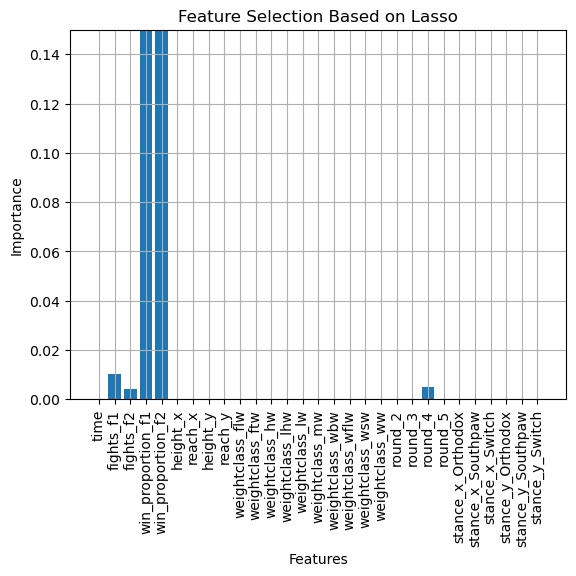

In [65]:
names=cleaned_features1.drop("outcome", axis=1).columns
lasso1 = Lasso(alpha=0.01)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns. 
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

In [66]:
from sklearn.linear_model import LassoCV

#Lasso Cross validation
lasso_cv = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=0).fit(X_train, y_train)


#score
print(lasso_cv.score(X_train, y_train))
print(lasso_cv.score(X_test, y_test))
best_alpha = lasso_cv.alpha_

print("Best alpha:", best_alpha)

0.4733694795580866
0.45753886467230376
Best alpha: 0.01


C:\Users\ddron\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3111710850790246, tolerance: 0.06817085427135677
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\ddron\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5827756755696782, tolerance: 0.06815624551328076
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\ddron\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9566475507325549, tolerance: 0.06770136396267047
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\ddron\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.p